# Lens depth functions
As mentioned in Kleindessners Thesis, size of the lens between two datapoints can serve as a proxy for the distance between the points. In the case of "most-central" triplets,
we can try to use this proxy for imputing missing answers in the questionnaire.

In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import altair as alt
import cblearn.datasets as datasets
from cblearn.preprocessing import triplets_from_mostcentral
from cblearn.datasets import make_random_triplets
from data_generation import generate_gmm_data_fixed_means
from sklearn.metrics import pairwise_distances
from questionnaire import Questionnaire, unify_triplet_order 
from estimators import OrdinalTangles, SoeKmeans
from triplets import subsample_triplets, LensMetric
from cblearn.embedding import SOE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from plotting import AltairPlotter
from tangles.cut_finding import kernighan_lin
from sklearn.neighbors import DistanceMetric
import networkx as nx
from utils import compare_to_soe
import matplotlib.pyplot as plt

In [2]:
seed = 8
data = generate_gmm_data_fixed_means(n=50, means=np.array([[-6,3], [6,3], [-6,-3]]), std=1, seed=seed)
p = AltairPlotter()
p.assignments(data.xs, data.ys)

alt.Chart(...)

In [3]:
tangles = OrdinalTangles(30)
q = Questionnaire.from_metric(data.xs, density=0.001, seed=seed)
ys_tangles = tangles.fit_predict(q.values)
_ = compare_to_soe(*q.to_bool_array(), data.ys, ys_tangles, 2, 3, seed)
print(f"# triplets: {q.values.size}")

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 150/150 [00:00<00:00, 75148.78it/s]

SOE-kMeans NMI: 0.6782672296680269
Tangles NMI: 1.0 (3)
# triplets: 1800


We can see, Tangles clusters the data well with a density-based approach. If we sample triplets uniformly on the other hand...

In [4]:
tangles = OrdinalTangles(30)
t, r = make_random_triplets(data.xs, "list-boolean", size=2000)
q = Questionnaire.from_bool_array(t, r).impute("random")
ys_tangles = tangles.fit_predict(q.values)
embedding, _ = compare_to_soe(t, r, data.ys, ys_tangles, 2, 3, seed)

SOE-kMeans NMI: 1.0
Tangles NMI: 0.0 (0)


Not so much. We need some kind of imputation. This will be done with the LD.
We will first draw most-central triplets, then estimate the distances with LD.

In [5]:
t_m, r_m = subsample_triplets(data.xs, number_of_triplets=5000, return_mostcentral=True)
t = triplets_from_mostcentral(t_m, r_m)
r = np.ones(t.shape[0]).astype(bool) 

q_m = Questionnaire.from_most_central_triplets(t_m, r_m, density=1.0, normalize=True)
# both versions don't work
# q = Questionnaire.from_bool_array(t, r).fill_with(q_m)
q = q_m
tangles = OrdinalTangles(20)
ys_tangles = tangles.fit_predict(q.values)
print(f"{tangles.score(q.values, data.ys)} ({np.unique(ys_tangles).size})")
p.assignments(data.xs, ys_tangles)

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 150/150 [00:00<00:00, 165.12it/s]


0.39299803673520156 (2)


alt.Chart(...)

Doesn't work all too well. 
We will check out the true lens metric and see the performance on that questionnaire:

In [6]:
q = Questionnaire.from_metric(data.xs, metric=LensMetric())
tangles = OrdinalTangles(8)
ys_tangles = tangles.fit_predict(q.values)
print(f"Tangles NMI: {normalized_mutual_info_score(ys_tangles, data.ys)} ({np.unique(ys_tangles).size})")

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 150/150 [00:00<00:00, 196.91it/s]


Tangles NMI: 0.7474194878219296 (3)


In [7]:
p.assignments(data.xs, ys_tangles)

alt.Chart(...)

We will try to plot the cut induced from two points.

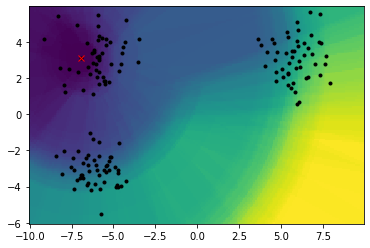

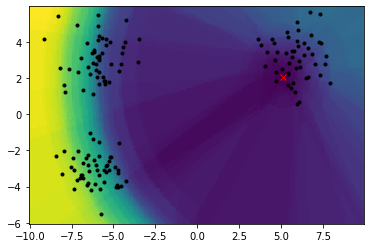

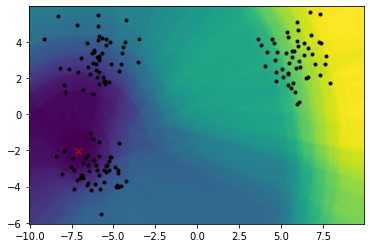

In [8]:
xs, ys = np.meshgrid(np.arange(-10, 10, 0.1), np.arange(-6, 6, 0.1))
def heatmap_of_point(xs, ys, point_idx, plot=True):
    cs = np.zeros_like(xs)
    metric = LensMetric()
    for i in range(xs.shape[0]):
        for j in range(xs.shape[1]):
            z = np.array([xs[i,j], ys[i,j]])
            c = metric.outside_point(data.xs, point_idx, z)
            cs[i, j] = c
    if plot:
        plt.pcolormesh(xs, ys, cs)
        plt.plot(data.xs[:, 0], data.xs[:, 1], '.k')
        plt.plot(data.xs[point_idx, 0], data.xs[point_idx, 1], 'xr')
        plt.show()
    return cs

p1 = 20
p2 = 80
p3 = 120
c1 = heatmap_of_point(xs, ys, p1)
c2 = heatmap_of_point(xs, ys, p2)
c3 = heatmap_of_point(xs, ys, p3)

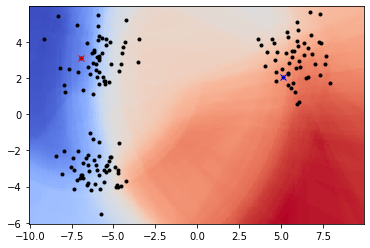

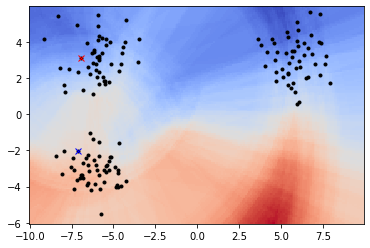

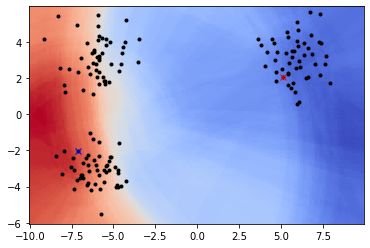

In [9]:
def plot_induced_cut(xs, ys, c1, c2, point_idx1, point_idx2):
    plt.pcolormesh(xs, ys, c1-c2, cmap="coolwarm")
    plt.plot(data.xs[:, 0], data.xs[:, 1], '.k')
    plt.plot(data.xs[point_idx1, 0], data.xs[point_idx1, 1], 'xr')
    plt.plot(data.xs[point_idx2, 0], data.xs[point_idx2, 1], 'xb')
    plt.show()
plot_induced_cut(xs, ys, c1, c2, p1, p2)
plot_induced_cut(xs, ys, c1, c3, p1, p3)
plot_induced_cut(xs, ys, c2, c3, p2, p3)

In [10]:
def plot_cut_between(q, idx1, idx2):
    i = q.labels.index((idx1, idx2))
    if i is None:
        i = q.labels.indes((idx2, idx1))
        inv = True
        p.assignments(data.xs, ~q.values[:, i]).display()
    else:
        p.assignments(data.xs, q.values[:, i]).display()
plot_cut_between(q, p1, p2)
plot_cut_between(q, p1, p3)
plot_cut_between(q, p2, p3)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

We see that the cuts look a lot like what has been predicted in the colormaps. We guess that Tangles cannot really divide that data due to the 
central triplets (part of the top left) not admitting clean cuts at all, since they are
biased to come up very often in the lenses. To alleviate this bias, we might want to create a kNN graph first (this is a bit dubious though, what purpose did Tangles have then?).

An alternative idea would be to just consider points close that have lens distance < k. This is quickly implemented.

In [11]:
dists = LensMetric().pairwise(data.xs)
cuts = dists < 30
tangles = OrdinalTangles(20)
ys_tangles = tangles.fit_predict(cuts)
print(f"Tangles NMI: {normalized_mutual_info_score(ys_tangles, data.ys)} ({np.unique(ys_tangles).size})")
p.assignments(data.xs, ys_tangles)

Tangles NMI: 0.94878832043511 (3)


alt.Chart(...)

Kind of annoyed that this works, it's so stupid. Let us see how well we can
estimate the lense from triplets.

In [12]:
t,r = subsample_triplets(data.xs, number_of_triplets=50000, return_mostcentral=True)
dists = LensMetric().pairwise_triplets(t,r, normalize=True)

In [13]:
cuts = dists < (30/148)
tangles = OrdinalTangles(22)
ys_tangles = tangles.fit_predict(cuts)
print(f"Tangles NMI: {normalized_mutual_info_score(ys_tangles, data.ys)} ({np.unique(ys_tangles).size})")
p.assignments(data.xs, ys_tangles)

Tangles NMI: 0.6943255734915952 (3)


alt.Chart(...)

Seems like a lot of triplets are necessary to estimate the Lens function correctly... this makes the approach unappealing.

# Lens function and kNN graph

In [14]:
graph_cuts = kernighan_lin(dists < (20/148), nb_cuts=20, lb_f=0.1, seed=seed, verbose=0, early_stopping=5)
# 
q = Questionnaire.from_bipartitions(graph_cuts.T)
tangles = OrdinalTangles(20)
ys_tangles = tangles.fit_predict(q.values)
print(f"Tangles NMI: {normalized_mutual_info_score(ys_tangles, data.ys)} ({np.unique(ys_tangles).size})")
p.assignments(data.xs, ys_tangles)

Tangles NMI: 0.546321212163027 (3)


alt.Chart(...)